In [1]:
%matplotlib inline
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy import signal
import peakutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, datetime
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from mpl_toolkits.mplot3d import Axes3D

In [5]:
char_inps = pd.read_csv("CHARACTER_INPUTS.csv", index_col=0)

In [7]:
char_inps[char_inps.columns[5:]].values

array([[ -77.,  -47.,  -18., ...,   68.,   50.,   33.],
       [-116., -142., -151., ..., -328., -285., -248.],
       [-109., -119., -147., ...,  166.,  184.,  180.],
       ..., 
       [-210., -297., -301., ...,  690.,  679.,  656.],
       [ -21.,  -59., -116., ...,   42.,    4.,  -40.],
       [ -84.,  -86.,  -42., ...,    0.,    0.,    0.]])

In [54]:
char_inps.head()

,peak time,signal,start time,end time,char,0,1,2,3,4,...,9591,9592,9593,9594,9595,9596,9597,9598,9599,9600
0,0.292000,1880.363647,0.272000,0.472000,a,-77,-47,-18,-45,-74,...,61,34,38,45,19,8,45,68,50,33
1,0.898667,4298.897461,0.878667,1.078667,l,-116,-142,-151,-179,-247,...,-311,-379,-395,-387,-354,-316,-320,-328,-285,-248
2,1.239333,3932.025391,1.219333,1.419333,i,-109,-119,-147,-188,-239,...,265,200,164,167,163,137,134,166,184,180
3,1.617333,51966.175781,1.597333,1.797333,c,497,470,439,420,445,...,26,20,29,6,-39,-54,-72,-111,-117,-88
4,1.906667,1297.764526,1.886667,2.086667,e,223,241,208,185,193,...,-141,-177,-182,-174,-134,-57,-4,-12,-32,-30


In [65]:
wave_len = 0.04
shift_start_back = 2

# Takes in sequential order of numpy arrays representing window for keypress 
# Outputs (keypress x 80) numpy array with cepstrum applied to it
def extract_cepstrum(keypress_sigs, rate, mfcc_start=2, mfcc_end=9):
    keypress_feats = []
    for keypress_sig in keypress_sigs:
        mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
        winstep=0.0025, numcep=16, nfilt=32, 
        lowfreq=400, highfreq=12000)
        keypress_feats.append(np.concatenate(mfcc_feat[mfcc_start:mfcc_end, :]).T)
    data = np.vstack(keypress_feats)
    return data

def run_hmm(data, targ_s, whiten_data=True, num_clusters=50, space_smooth=5, trans_smooth=1):
    if whiten_data:
        data = whiten(data)
    kmeans = KMeans(n_clusters=num_clusters).fit(data)

    # Get labels from running clustering
    labels = kmeans.labels_.reshape(-1, 1)

    # Init spaces to reasonable values
    space_inds = [i for i, letter in enumerate(targ_s) if letter == " "][:10]
    spaces = kmeans.labels_[space_inds]

    # Build transition matrix
    trans_m = np.zeros((27, 27)) + trans_smooth
    for i in range(len(targ_s)-1):
        c, next_c = ord(targ_s[i]) - 97, ord(targ_s[i+1]) - 97
        if c < 0:
            c = 26
        if next_c < 0:
            next_c = 26
        trans_m[c][next_c] += 1
    row_sums = trans_m.sum(axis=1)
    trans_m = trans_m / row_sums[:, np.newaxis]

    # Build emission matrix
    emiss_m = np.random.rand(27, num_clusters)
    space_vec = np.zeros((num_clusters)) + space_smooth
    for i in spaces:
        space_vec[i] += 1
    emiss_m[26, :] = space_vec
    row_sums = emiss_m.sum(axis=1)
    emiss_m = emiss_m / row_sums[:, np.newaxis]

    # Create HMM
    hmm = MultinomialHMM(n_components=27, verbose=True, init_params="e", params="se", tol=1e-4, n_iter=5000) 
    hmm.n_features = num_clusters
    hmm.transmat_ = trans_m
    hmm.emissionprob_ = emiss_m
    
    # Fit and decode
    hmm = hmm.fit(labels)
    logprob, pred = hmm.decode(labels, algorithm='viterbi')
    
    return hmm, logprob, pred

def transform_to_str(pred):
    s = ''
    for i in pred:
        if i == 26:
            s += ' '
        else:
            s += chr(97 + i)
    return s

(rate,sig) = wav.read("alice_slow.wav")
sig = sig[:, 1]

# t -> X, time
# f -> Y, frequency in HZ
# Sxx -> C, actual values themselves
f, t, Sxx = signal.spectrogram(sig, rate)

targ_s = "alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind as well as she could for the day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white abbit with pink eyes ran close by her there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear oh dear i shall be too late but when the rabbit actually took a watch out of its waistcoat pocket and looked at it and then hurried on alice started to her feet for it flashed across her mind that she had never before seen a rabbit with either a waistcoat pocket or watch to take out of it and burning wit curiosity she ran acrross the field after it and was just in time to see it pop down a large rabbit hole under the hedge in another moment down went alice after it the rabbit hole went straight on like a tunnel for some way and then dipped sudddenly down so suddenly that alice had not a moment to think about stopping herself before she found herself falling down what seemed to be a very deep well either the well was very deep or she fell very slowly for she had plenty of time as she went down to look about her first she tried to make out what she was coming to but it was too dark to see anything then she looked at the sides of the wall and noticed that they were filled with cupboards and book shelves here and there she saw maps and pictures hung upon pegs she took down a jar from one of the shelves she passed it was labeled orange marmalade but to her great disappointment it was empty she did not like to drop the jar so managed to put it into one of the cupboardsa as she fell past it down down down would the fall never come to an end there was nothing ele to do"
sig_str = np.sum(Sxx[2:71, :], axis=0)

# According to paper, usually around 100ms left between 
# conseuctive keystrokes so min_dist should be around 20
# Difference between adjacent signals is 5ms
indexes = peakutils.indexes(sig_str, thres=0.010, min_dist=20)
len(indexes), len(targ_s)

# Maybe just do some parameter tuning, try to maximize number of unique words found in set
# Find and extract all parameters that can be taken out
# Try to use dataframes
keypress_sigs = []
for i in range(len(indexes)):
    ind = indexes[i]
    # Take exactly 40 ms
    key_start = int(t[ind - shift_start_back] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sigs.append(sig[key_start:key_end])        
data = extract_cepstrum(keypress_sigs, rate)

# hmm, logprob, pred = run_hmm(data, targ_s)

# print np.exp(logprob/(len(pred)))

# pred_set = set(pred_str.split())
# targ_set = set(targ_s.split())
# sim = targ_set.intersection(pred_set)
# print len(sim)

# pred_str = transform_to_str(pred)
# print pred_str

In [90]:
# Takes in sequential order of numpy arrays representing window for keypress 
# Outputs (keypress x 80) numpy array with cepstrum applied to it
def extract_cepstrum(keypress_sigs, rate, mfcc_start=2, mfcc_end=9):
    keypress_feats = []
    for keypress_sig in keypress_sigs:
        mfcc_feat = mfcc(keypress_sig, rate, winlen=0.04, 
        winstep=0.01, numcep=16, nfilt=32)
        # mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
        # winstep=0.0025, numcep=16, nfilt=32, 
        # lowfreq=400, highfreq=12000)
        # keypress_feats.append(np.concatenate(mfcc_feat[mfcc_start:mfcc_end, :]).T)
        keypress_feats.append(np.concatenate(mfcc_feat[mfcc_start:mfcc_end, :]).T)
        data = np.vstack(keypress_feats)
    return data

In [ ]:
char_inps = pd.read_csv("CHARACTER_INPUTS.csv", index_col=0)

In [ ]:
targ_s = "".join([" " if c == '#SPACE' else c for c in list(char_inps['char'].values)])
mike_char_data = char_inps[char_inps.columns[5:]].values
mike_keypress_data = np.split(mike_char_data, 1905, axis=0)
mike_keypress_data = [np.squeeze(l) for l in mike_keypress_data]
data = extract_cepstrum(mike_keypress_data, rate, mfcc_start=0, mfcc_end=19)

In [89]:
hmm, logprob, pred = run_hmm(data, targ_s)

         1       -7473.7251             +nan
         2       -7160.9063        +312.8189
         3       -7158.3687          +2.5376
         4       -7155.7325          +2.6362
         5       -7152.8184          +2.9141
         6       -7149.5036          +3.3148
         7       -7145.6681          +3.8355
         8       -7141.2008          +4.4673
         9       -7136.0186          +5.1822
        10       -7130.0805          +5.9381
        11       -7123.3755          +6.7051
        12       -7115.9126          +7.4628
        13       -7107.7336          +8.1790
        14       -7098.9093          +8.8243
        15       -7089.5194          +9.3899
        16       -7079.6614          +9.8580
        17       -7069.5017         +10.1597
        18       -7059.3031         +10.1986
        19       -7049.3692          +9.9339
        20       -7039.9484          +9.4208
        21       -7031.1791          +8.7693
        22       -7023.0954          +8.0838
        23

In [70]:
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice shad peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book throught alice without pictures of conversations so she was considering in her own mind as well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a diasy chain would be worth the trouble of getting up and picking the diases when suddenly a white rabbit with pink eyes ran close by her there was nothing so very remarkable in that nor diad alice think it so very much out of the way to hear the rabiit say to itself oh dear i shall be too late when she thought it over afterwards ti occurrered to her that she ought to have wondered at this but at the time it seemed quite natural but when the rabbit actually took a watch out of its pocket and looked at it and then hurried on alice when the rabbit actually to

In [84]:
print np.exp(logprob/(len(pred)))

pred_str = transform_to_str(pred)
pred_set = set(pred_str.split())
targ_set = set(targ_s.split())
sim = targ_set.intersection(pred_set)
print len(sim)

print pred_str

0.021084724432
16
t shan ase wan a ing tond asit the d okg as nkk the ithed tithange te t se the oke wooked the s then s th t o a icouts s owhe ting id wk titt thend wand rin ofloupoke wn wy wherge it and and ly blalxpjjqxxjxgvxxjxbbxxjbbbbbbjjxbgxxxmugg palllllisthoushentt se wit ache s as it wang t s ind ither a s it o ashen itourinithedokingenopoupoupbbbubbjjbbblvkjmxbupxjxbbupbbbimllalbly peller t the ditot at at ge inthe io s wn thandd wan tintotit sg ithe e t toke she d nd a s watin and n to shered the it and ak t it tt d oof as she cof t as shinde s wafthitithe s toonddgy sheand an tith thonjxflfwbbicupbctxkburyxcxxvxmrjujbupbjbouplxlvdjupxjbupoulvgxt imre fllliand as whe t tooug atour fitwjg d whe ofllondir llbick ccker sshe te it as l ge ter tougjupxxvmxxxvjjvupxjvxfjupouvxbbbubbvxbjuplqghe cerasuther ad nxwabjvkxuto burabbby pjxy boulbburale alind t he as herre ave the was sher okcen oced tcr he hedasitowat the t outthe t the thery atond cker wok t wallen imickmoflyelxlevlypo

In [102]:
indexes = peakutils.indexes(sig_str, thres=0.010, min_dist=20)
len(indexes)

1955

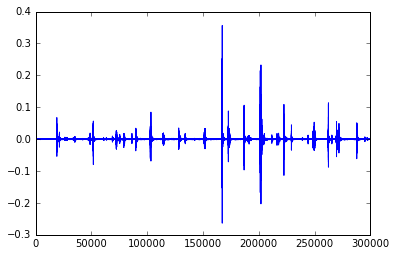

In [72]:
pd.Series(sig[500000:800000]).plot()

[   586    606    639 ..., 119013 119037 119068]


(2109, 2092)

In [78]:
print np.exp(logprob/(len(pred)))
pred_str = transform_to_str(pred)
print pred_st

0.0166055764504
xf pit dreld tr jqverellllice putin thelvqjqullay tha mjve wlme ofitce we itctuthe ot del itjy t whesheabiced slitor t s aid t helllllqqjpithen touthe picwat he to tindo o thallinthery t wicvelllapverar wndaber ar he cely t mqjuy thed ase she ashenos wock t wndat ad thjy t t sjjupind sablvqqwadookindqjhe t t bbbitckerar ly he aran ded mjrisery wxjjcjabink s suxy st t in oked ashed ckbuy feedoopitor withedeas thevpo wale mant t it t ind sher wlederk atokt curayedd wiersokithe thvkbbulithar t or t t h she he jasy he ty s asshas otour wowathe th mandima here t ad cerok toshad ind ayqpqbbby ipqjumadithe vgerockit wafjly bud hat ws s wble tookepaicokqkkver in watudgerabbladato sthas d n afot itor f wabuthathwinge sthedit bity ve ve ledjur plerindot ice oreeabithe wabcowathedastury an d atorake inngved t are jpppshep withelingqnd r sherichesthabkend wakpo what toke ond toupoud t ftoollelvbmithe the st f washey a t toury bur boulinjpojjshaty md blled picouthit tanowng he bupbd

['xf',
 'pit',
 'dreld',
 'tr',
 'jqverellllice',
 'putin',
 'thelvqjqullay',
 'tha',
 'mjve',
 'wlme',
 'ofitce',
 'we',
 'itctuthe',
 'ot',
 'del',
 'itjy',
 't',
 'whesheabiced',
 'slitor',
 't',
 's',
 'aid',
 't',
 'helllllqqjpithen',
 'touthe',
 'picwat',
 'he',
 'to',
 'tindo',
 'o',
 'thallinthery',
 't',
 'wicvelllapverar',
 'wndaber',
 'ar',
 'he',
 'cely',
 't',
 'mqjuy',
 'thed',
 'ase',
 'she',
 'ashenos',
 'wock',
 't',
 'wndat',
 'ad',
 'thjy',
 't',
 't',
 'sjjupind',
 'sablvqqwadookindqjhe',
 't',
 't',
 'bbbitckerar',
 'ly',
 'he',
 'aran',
 'ded',
 'mjrisery',
 'wxjjcjabink',
 's',
 'suxy',
 'st',
 't',
 'in',
 'oked',
 'ashed',
 'ckbuy',
 'feedoopitor',
 'withedeas',
 'thevpo',
 'wale',
 'mant',
 't',
 'it',
 't',
 'ind',
 'sher',
 'wlederk',
 'atokt',
 'curayedd',
 'wiersokithe',
 'thvkbbulithar',
 't',
 'or',
 't',
 't',
 'h',
 'she',
 'he',
 'jasy',
 'he',
 'ty',
 's',
 'asshas',
 'otour',
 'wowathe',
 'th',
 'mandima',
 'here',
 't',
 'ad',
 'cerok',
 'toshad',


In [86]:
# If word is reasonably close to an English word, correct spelling
# Add the indices of this new word to a training set
# Use an RNN or something to train on it
# Apply spelling corrections again, etc.

14
